# Machine Learning: Intermediate report

+ Your name (Your ID)

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following three (and one optional) problems, and submit the notebook (`.ipynb`) as well as its HTML conversion (`.html`). *We do not accept a report in other formats (e.g., Word, PDF)*. Write a code at the specified cell in the notebook. One can add more cells if necessary.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearningclass/blob/master/mlp_binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearningclass/blob/master/mnist.ipynb)

## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the accuracy of the model on the test set. One can use the same code shown in the lecture. Write a code here and show the output.

In [0]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
  magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
  assert magic==0x00000803
  assert rows==28
  assert columns==28
  rawbuffer=fi.read()
  assert len(rawbuffer)==n*rows*columns
  rawdata=np.frombuffer(rawbuffer,dtype='>u1',count=n*rows*columns)
  #dtype>u1:符号なし8ビット整数型を表現　　ビッグエンディアン
  #np.frombuffer https://docs.scipy.org/doc/numpy/reference/generated/numpy.frombuffer.html
  return rawdata.reshape(n,rows,columns).astype(np.float32)/255.0

def read_label(fi):
  magic,n=struct.unpack(">ll",fi.read(8))
  assert magic == 0x00000801
  rawbuffer=fi.read()
  assert len(rawbuffer)==n
  return np.frombuffer(rawbuffer,dtype='>u1',count=n)

if __name__=='__main__':
  os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
  os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
  os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
  os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
  
  np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )
  #https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.savez_compressed.html

In [3]:
import numpy as np
data=np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


5


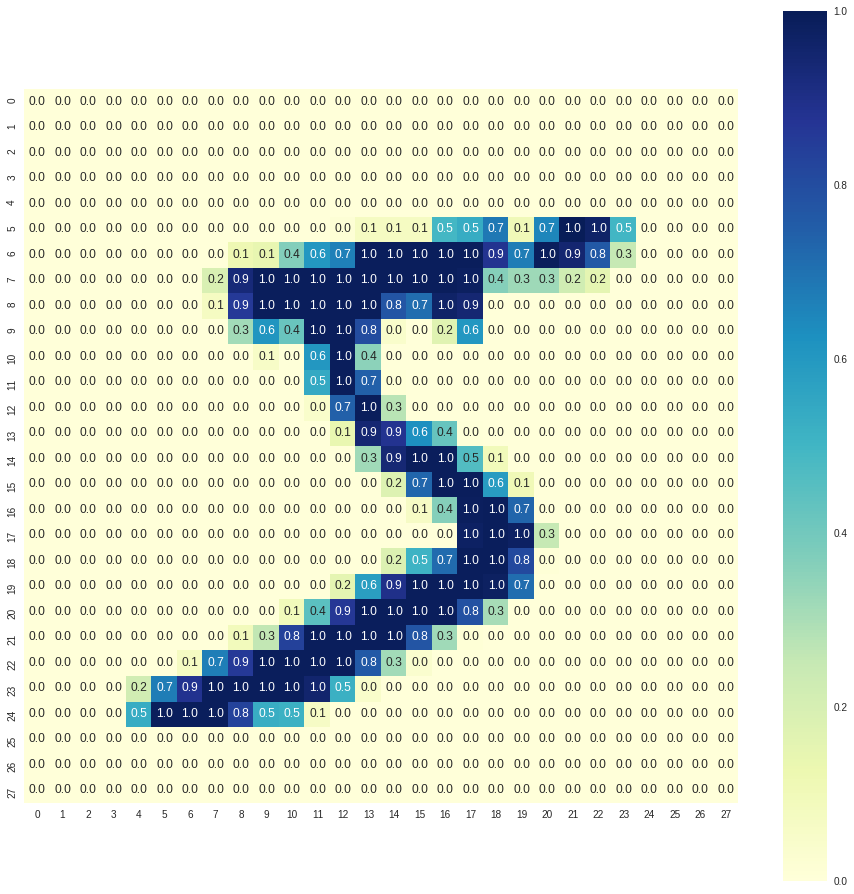

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Index number of an instance (change this to view another instance)
i=0

data=np.load('mnist.npz')
image=data['train_x'][i]
label=data['train_y'][i]

print(label)
f,ax=plt.subplots(figsize=(16,16))
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html
sns.heatmap(image,annot=True,fmt='.1f',square=True,cmap="YlGnBu")
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#annot:Trueにすると各セルにデータ値を書き込む
#fmt:annotの書式,小数点1桁まで
#sqaure:Trueにすると各セルを正方形に
#cmap対応色:https://matplotlib.org/examples/color/colormaps_reference.html
plt.show()

In [5]:
!pip  install livelossplot

  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot


In [6]:
!pip install torch torchvision

    100% |████████████████████████████████| 519.5MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59dbc000 @  0x7fad3c0e91c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 1.5MB/s 
    100% |████████████████████████████████| 2.0MB 2.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
def create_dataset(x,y,flatten=False):
  if flatten:
    #Convert it into a matrix (N[samples],28*28[dims])
    xt=torch.from_numpy(x).view(len(x),-1)
  else:
    #Convert it into 4D tensor (N[samples],1[ch],28[px],28[px])
    xt=torch.from_numpy(x).unsqueeze(1)
  yt=torch.from_numpy(y).long()
  
  return TensorDataset(xt,yt)

def test_model(model,loss_fn,test_loader,device):
  model.eval()
  
  loss=0
  num_correct=0
  for batch_idx,(x,y) in enumerate(test_loader):
    x,y=x.to(device), y.to(device)
    y_pred=model(x)
    loss+=loss_fn(y_pred,y).item()
    _,predicted =torch.max(y_pred.data,1)
    num_correct+=(predicted==y).sum().item()
  
  model.train()
  loss /= len(test_loader.dataset)
  num_correct /= len(test_loader.dataset)
  return loss,num_correct


In [21]:
#CNN


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses


#device=torch.device("cpu")
device=torch.device("cuda:0")

def create_dataset(x,y):
  xt=torch.from_numpy(x).view(len(x),-1)
  #from_numpy (x)  x(np.ndarray)からテンソルを生成し、ndarrayとテンソルの反抗を互いに反映させる
  yt=torch.from_numpy(y).long()
  #self.long() is equivalent to self.to(torch.int64)
  return TensorDataset(xt,yt)

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)


model=torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    #Conv2d(入力の数,出力の数,畳み込みカーネルのサイズ)
    torch.nn.MaxPool2d(2),
    #MaxPool2d(プーリングのウインドウサイズ)
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),    
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
  )


print(model)
model.to(device)


data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss()
#size_average:Falseにすると各ミニバッチの損失が合計される
optimizer=optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)
    
    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout(p=0.5)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Dropout(p=0.5)
  (8): Flatten()
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5)
  (12): Linear(in_features=256, out_features=10, bias=True)
)


RuntimeError: ignored

## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/PIETEP/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

## 3. Top-3 confusing examples

Show the top three images where the model misrecognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n \neq \hat{y}_n$.

Please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$. This is an example of an output for an image (you need this kind of outputs for top-three images).

![example](https://github.com/PIETEP/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

## 4. Sample codes in other DL frameworks

(Advanced; optional) Implement one or more sample code(s) with a different deep learning framework (e.g., Chainer, TensorFlow, DyNet) corresponding to the slides 60-66 in binary classification. *When subitting an answer to this problem, please agree that some of the submitted codes will be distributed on the Web site to improve this lecture.*